In [39]:
from rdkit import Chem
import pandas as pd

atoms = [
    'H',
    'C',
    'N',
    'O',
    'P',
    'S',
    'F',
    'Cl',
    'Br',
    'I',
    'B',
    'Si'
    # Other
]
atoms = list(map(str.lower, atoms))
atom_map = {atoms[i]: i for i in range(len(atoms))}
ATOM_FEATURE_LEN = len(atoms) + 1

Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}
Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

SMILES_CHARS = [
                  '#', '%', '(', ')', '+', '-', '.', '/',
                  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  '=', '@',
                  '[', '\\', ']']

FEATURE_LEN_NO_SMILES = ATOM_FEATURE_LEN + 6 + len(Chiral) - 1 + len(Hybridization) - 1
FEATURE_LEN =  FEATURE_LEN_NO_SMILES + len(SMILES_CHARS)

smiles_char_map = {SMILES_CHARS[i]: i + FEATURE_LEN_NO_SMILES for i in range(len(SMILES_CHARS))}

def atom_feature(atom):
    feature = [0] * ATOM_FEATURE_LEN
    sym = atom.GetSymbol().lower()
    if sym in atom_map:
        feature[atom_map[sym]] = 1
    else:
        feature[len(atom_map)] = 1
        
#     if atom.GetSymbol() == 'H':   feature = [1,0,0,0,0]
#     elif atom.GetSymbol() == 'C': feature = [0,1,0,0,0]
#     elif atom.GetSymbol() == 'O': feature = [0,0,1,0,0]
#     elif atom.GetSymbol() == 'N': feature = [0,0,0,1,0]
#     else: feature = [0,0,0,0,1]
        
    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    feature.extend([0] * (FEATURE_LEN - len(feature)))
    
    # feature.extend([0] * len(smiles_char_map))
    return feature

def smile_symbol_feature(character):
    feature = [0] * FEATURE_LEN
    feature[smiles_char_map[character]] = 1
    return feature

In [40]:
def features_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    c = 0
    a = 0
    n_atoms = mol.GetNumAtoms()
    n_chars = len(smiles)
    features = []
    while c < n_chars or a < n_atoms:
        if smiles[c] in smiles_char_map:
            features.append(smile_symbol_feature(smiles[c]))
            c += 1
        elif smiles[c] == 'H':
            f = [0] * (FEATURE_LEN)
            f[0] = 1
            features.append(f)
            c += 1
        else:
#             print(smiles[c])
#             print(repr(mol.GetAtomWithIdx(a).GetSymbol()))
            features.append(atom_feature(mol.GetAtomWithIdx(a)))
            c += len(mol.GetAtomWithIdx(a).GetSymbol())
            a += 1
    return features

In [41]:
df = pd.read_csv("Lipophilicity.csv")
df.pop('CMPD_CHEMBLID')
# display(df)

smiles = [("Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14", 3.54), ("OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4", 3.14), ("O=C1CCCCCN1", -0.8), ("CNC(=O)C1(CCN(CC[C@H](CN(C)C(=O)c2c(OC)c(cc3ccccc23)C#N)c4ccc(Cl)c(Cl)c4)CC1)N5CCCCC5=O", 2.78)]
features = []
labels = []
maxlen = 0
for index, row in df.iterrows():
    s = row['smiles']
    l = row['exp']
# for s, l in smiles:
    print(s, l)
    f = features_from_smiles(s)
    if len(f) > maxlen:
        maxlen = len(f)
    features.append(f)
    labels.append(l)

zeros = [0] * FEATURE_LEN
for f in features:
    f.extend([zeros] * (maxlen - len(f)))

# s = normalize_smiles("CNC(=O)C1(CCN(CC[C@H](CN(C)C(=O)c2c(OC)c(cc3ccccc23)C#N)c4ccc(Cl)c(Cl)c4)CC1)N5CCCCC5=O")
# print(s)
# features_from_smiles(s)

cc(OC)cc3OC 3.52
CC(C)OC(=O)N1CCC(CC1)Oc2ncnc3N(CCc23)c4ccc(cc4F)S(=O)(=O)C 3.4
CCO\N=C(\C1CCN(CC1)C2(C)CCN(CC2)C(=O)c3c(Cl)cncc3Cl)/c4ccc(Br)cc4 4.0
C[C@H]1O[C@H]([C@H](O)[C@@H]1O)n2cnc3c(N)nc(OCC4CC45CC5)nc23 1.78
CCN(C1CCN(CCC(N2CCN(CC2)c3cccc(F)c3)c4ccccc4)CC1)C(=O)Cc5ccc(cc5)S(=O)(=O)C 3.21
FC(F)(F)c1cccc(c1)S(=O)(=O)NC(=O)N2CCC(CC2)N3CCC(CC3)Oc4ccc(Cl)c(Cl)c4 2.94
OC(=O)CCC(=O)N1CCC(CC1)c2onc(n2)c3cccs3 -1.27
Oc1ccc2C(=O)N(C(=O)c2c1)c3ccccc3 2.3
COc1ccc2C=CC(=O)N(CCN3CCC(CC3)NCc4cc5OCCOc5cn4)c2n1 1.16
Cc1cc(C)nc(SCC(=O)N)n1 0.23
Cc1oc(CN2NC(=O)C3=C(C2=O)C(=O)c4ccc(Cl)cc4N3)cc1C 1.0
O[C@@H](CNCCCSCCNCCc1cccc(Cl)c1)c2ccc(O)c3NC(=O)Sc23 1.06
Cc1ccsc1C(=CCCN2CCC[C@H](C2)C(=O)O)c3sccc3C 1.49
CC1Cc2ccccc2N1NC(=O)c3ccc(Cl)c(c3)S(=O)(=O)N 1.83
C[C@H]1CN(Cc2cc(Cl)ccc2CC(=O)O)CCN1C(=O)Cc3ccc(Cl)cc3 1.66
C[C@@](N)(Cc1ccccc1)c2ccccc2 1.7
Cc1cc(CN2Cc3ccccc3C2C(=O)Nc4cc(Cl)ccc4Cl)ccc1OCC(=O)O 2.19
CCC(CC)NC(=O)c1c(C)nn(C(C)C)c1NS(=O)(=O)c2ccc(C)cc2 0.92
Cc1ccc(cc1NC(=O)c2ccc(OCc3ccccn3)cc2)c4c

In [42]:
# len(features[0][0])
# for mol in features:
#     for feature in mol:
#         print(len(feature))
# import pandas as pd
import numpy as np

np_features = np.array(features)
np_features.shape

(4200, 267, 52)

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential()
model.add(layers.Conv1D(32, 10, input_shape=(267, 52), activation='relu'))
model.add(layers.MaxPool1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.1))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='linear'))

model.summary()

model.compile(loss='mean_squared_error', optimizer='adam')
reset = model.get_weights()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 258, 32)           16672     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 129, 32)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 129, 32)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 128, 64)           4160      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 62, 64)           

420/420 [==============================] - 0s 1ms/sample - loss: 6.0108


6.010835075378418

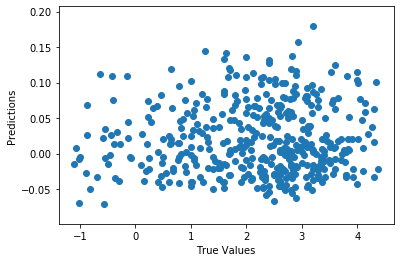

In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(np_features, labels, test_size=0.1)

pred = model.predict(X_test)
plt.scatter(y_test, pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

model.evaluate(X_test, y_test, verbose=1)

In [57]:
# model.fit(x=X_train, y=y
model.fit(x=X_train, y=y_train, epochs=100, verbose=1)

Epoch 1/100
3780/3780 [==============================] - 5s 1ms/sample - loss: 1.5477
Epoch 2/100
3780/3780 [==============================] - 4s 1ms/sample - loss: 1.2968
Epoch 3/100
3780/3780 [==============================] - 4s 1ms/sample - loss: 1.1703
Epoch 4/100
3780/3780 [==============================] - 4s 1ms/sample - loss: 1.0298
Epoch 5/100
3780/3780 [==============================] - 4s 1ms/sample - loss: 0.9337
Epoch 6/100
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.8079
Epoch 7/100
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.7740
Epoch 8/100
3780/3780 [==============================] - 4s 1ms/sample - loss: 0.6949
Epoch 9/100
3780/3780 [==============================] - 4s 1ms/sample - loss: 0.6614
Epoch 10/100
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.6235
Epoch 11/100
3780/3780 [==============================] - 5s 1ms/sample - loss: 0.5726
Epoch 12/100
3780/3780 [============================

420/420 [==============================] - 0s 440us/sample - loss: 0.7405


0.7404514562515986

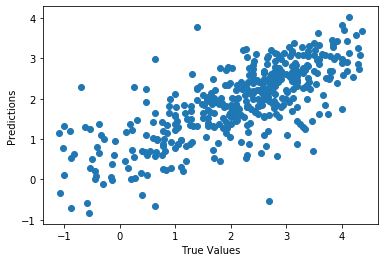

In [58]:
pred = model.predict(X_test)
plt.scatter(y_test, pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
model.evaluate(X_test, y_test)

Well, it's better than nothing